# *supertrab - trabecular bone histomorphometry tests*
From a segmented micro-CT image to quantification of trabecular bone histomorphometry

Created on:  04.04.2025 <br />
Last update: 23.06.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk)
- Code license: MIT
- Narrative license: CC-BY-NC-SA

### Packages used in this notebook
- [ORMIR_XCT](https://github.com/ORMIR-XCT/ORMIR_XCT) is used for the calculation of trabecular thickness in 3D
- [pyfabric](https://github.com/gianthk/pyfabric) contains notebooks showing how to segment and process 3D images of trabecular bone
- [recon_utils](https://github.com/gianthk/recon_utils) contains image processing utilities

---
# Computational workflow
## Configuration and imports

In [3]:
import os
import sys

In [4]:
# terminus
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/pyfabric')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/ORMIR_XCT')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/recon_utils')

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu, threshold_otsu, gaussian
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import SimpleITK as sitk

from imaging_utils import periosteummask, remove_unconnected
# from resources.myshow import myshow, myshow3d
from recon_utils import read_tiff_stack, plot_midplanes, bbox
# import pyfabric
# from resources.pyfabric_image_utils import dist_table, markers_coors, resample_img, vectors2rotation3Dmatrix, align_with_XYplane, align_with_vectors, resample, affine_trans

astropy module not found
olefile module not found


In [6]:
from ormir_xct.util.hildebrand_thickness import calc_structure_thickness_statistics

In [7]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

## Load data

In [8]:
data_folder = '/usr/terminus/data-xrm-01/stamplab/external/LHTL/3155_D_4_bc/cropped/'

#### Load input trabecular bone image
Scan Settings:

* voxelsize: 19.5 um

Read the input data and define an array of the voxelsize

In [18]:
input_file = os.path.join(data_folder, '3155_D_4_bc_0000.tiff')
data_3D = read_tiff_stack(input_file)
# data_3D = np.rot90(read_tiff_stack(input_file), k=1, axes=(1, 2))
# data_3D = np.transpose(read_tiff_stack(input_file), axes=(1, 0, 2))

# voxelsize
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

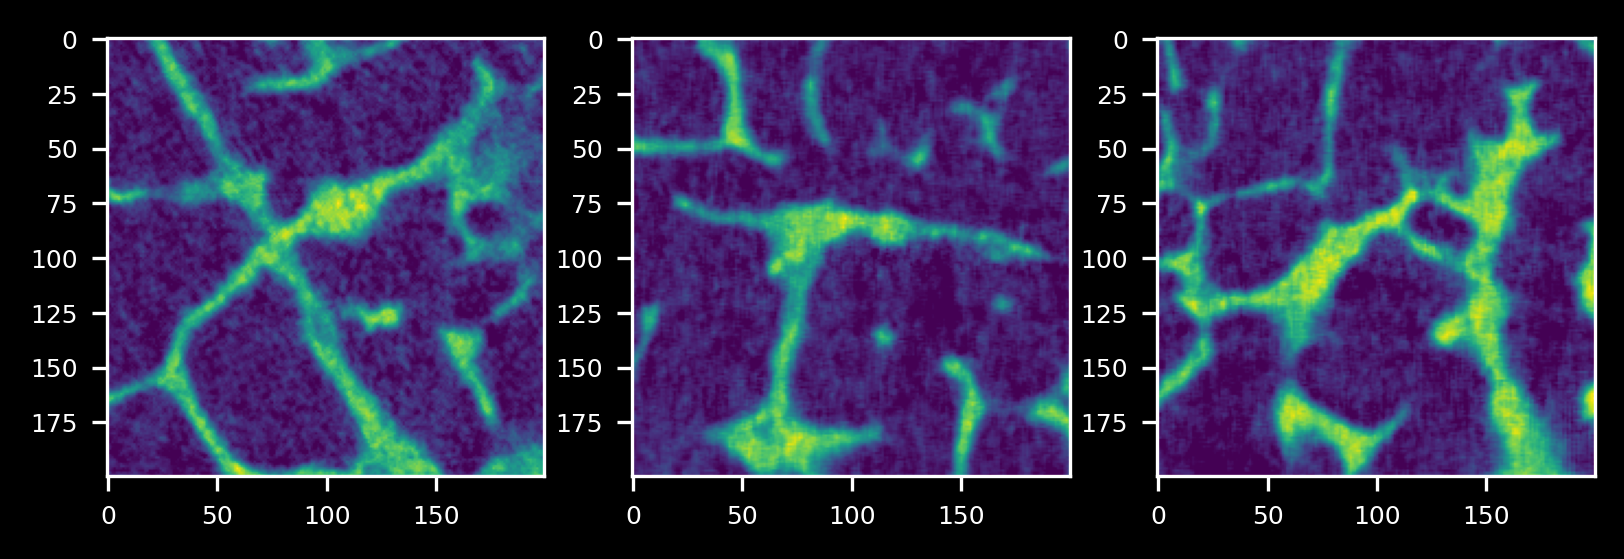

In [10]:
plot_midplanes(data_3D)

## Pre-processing
### Gaussian smooth

In [11]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

## Segmentation
### Otsu thresholding

In [12]:
# calculate threshold using Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.92566349845593


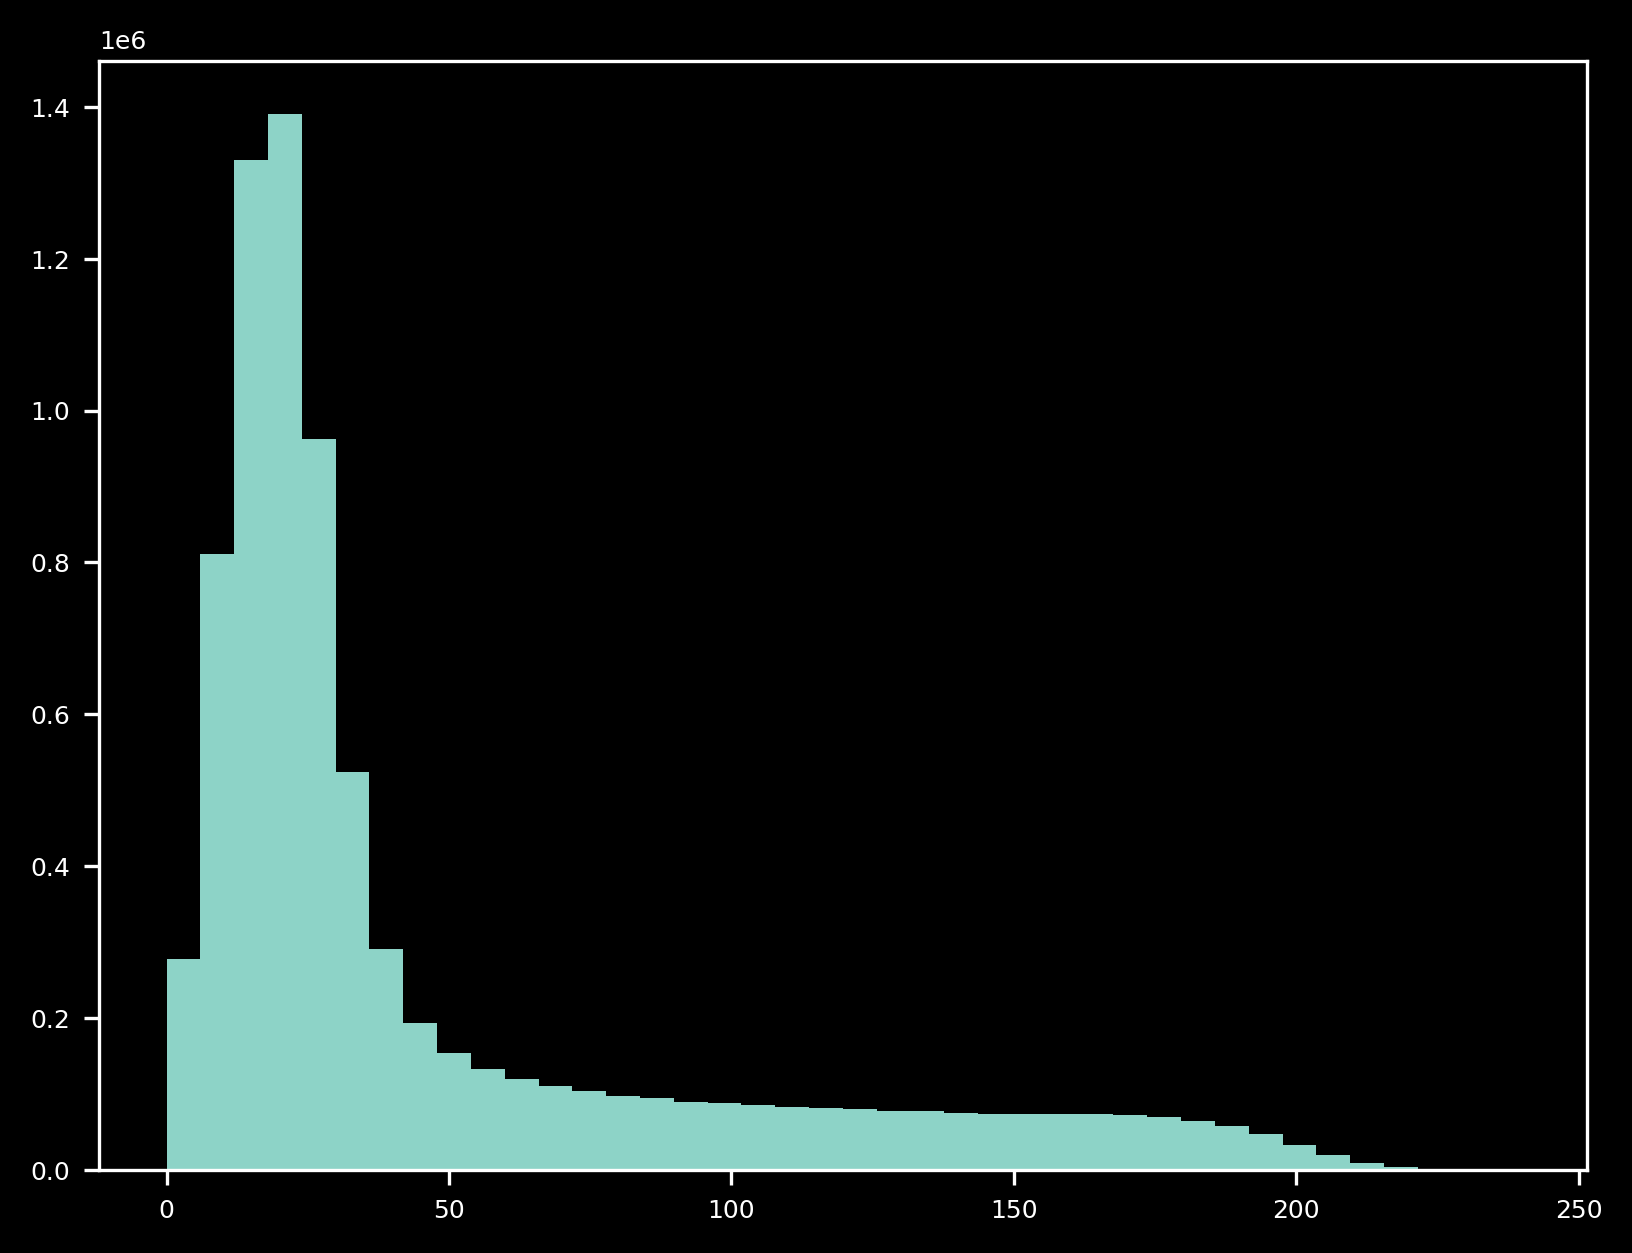

In [13]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

### For the LHTL dataset we can rely on a comparison with histology
We know that the real threshold value is 63

In [14]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

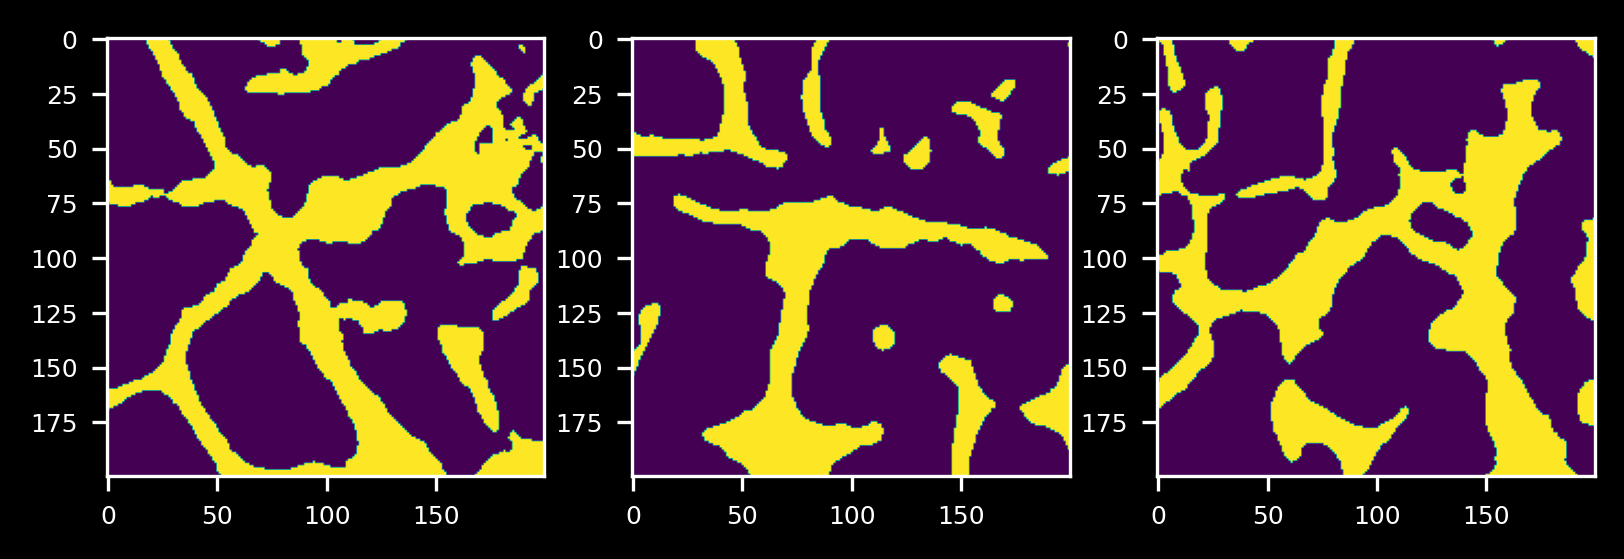

In [15]:
# inspect the binary mask
plot_midplanes(BW)

### Bounding Box of the specimen
A bounding box is the pixel coordinates of a box surrounding the sample. It is useful if you want to crop the parts of the 3D volume that contain only background

In [19]:
# bboxx = bbox(BW)
# print('bbox: ', bboxx)

In [20]:
# # crop the binary mask to the bounding box
# BW2 = BW[bboxx[0][2]:bboxx[1][2], bboxx[0][0]:bboxx[1][0], bboxx[0][1]:bboxx[1][1]].astype('bool')
# plot_midplanes(BW2)

## Binary mask operations
### Remove unconnected regions

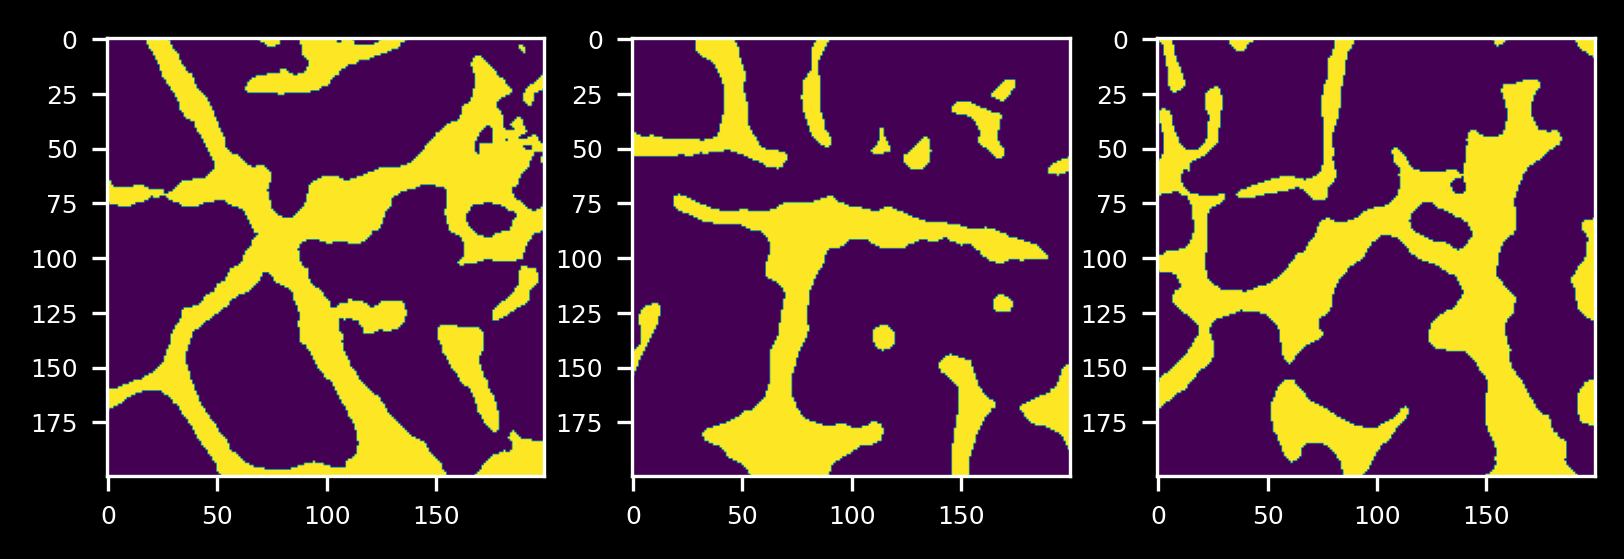

In [16]:
BW2 = remove_unconnected(BW)
plot_midplanes(BW2)

## Histomorphometry calculations
### BV/TV (bone volume fraction)

In [17]:
bvtv1 = np.sum(BW)/np.prod(BW.shape)
bvtv2 = np.sum(BW2)/np.prod(BW2.shape)
print('BV/TV: ', bvtv1)
print('BV/TV (without unconnected): ', bvtv2)

BV/TV:  0.2337425
BV/TV (without unconnected):  0.2336995


### Trabecular thickness (Tb.Th)

In [19]:
thickness_stats = calc_structure_thickness_statistics(BW2, vs, 0)
print(
    f"Thickness: {thickness_stats[0]:0.3f} +/- {thickness_stats[1]:0.3f}"
)

Thickness: 0.248 +/- 0.108


### Trabecular separation
Invert the mask and repeat Tb.Th calculation

In [20]:
separation_stats = calc_structure_thickness_statistics(~BW2, vs, 0)
print(
    f"Separation: {separation_stats[0]:0.3f} +/- {separation_stats[1]:0.3f}"
)

Separation: 0.786 +/- 0.219


## Modify the mask with binary erosion to reduce the Tb.Th

In [27]:
erosion_radius = 35*1e-3 # in [mm]
erosion_voxels = erosion_radius / vs[0]  # assuming isotropic voxels
print(f"Erosion radius: {erosion_radius} mm, voxels: {erosion_voxels}")
BW3 = morphology.binary_erosion(BW2, morphology.ball(1.8))

Erosion radius: 0.035 mm, voxels: 1.794871794871795


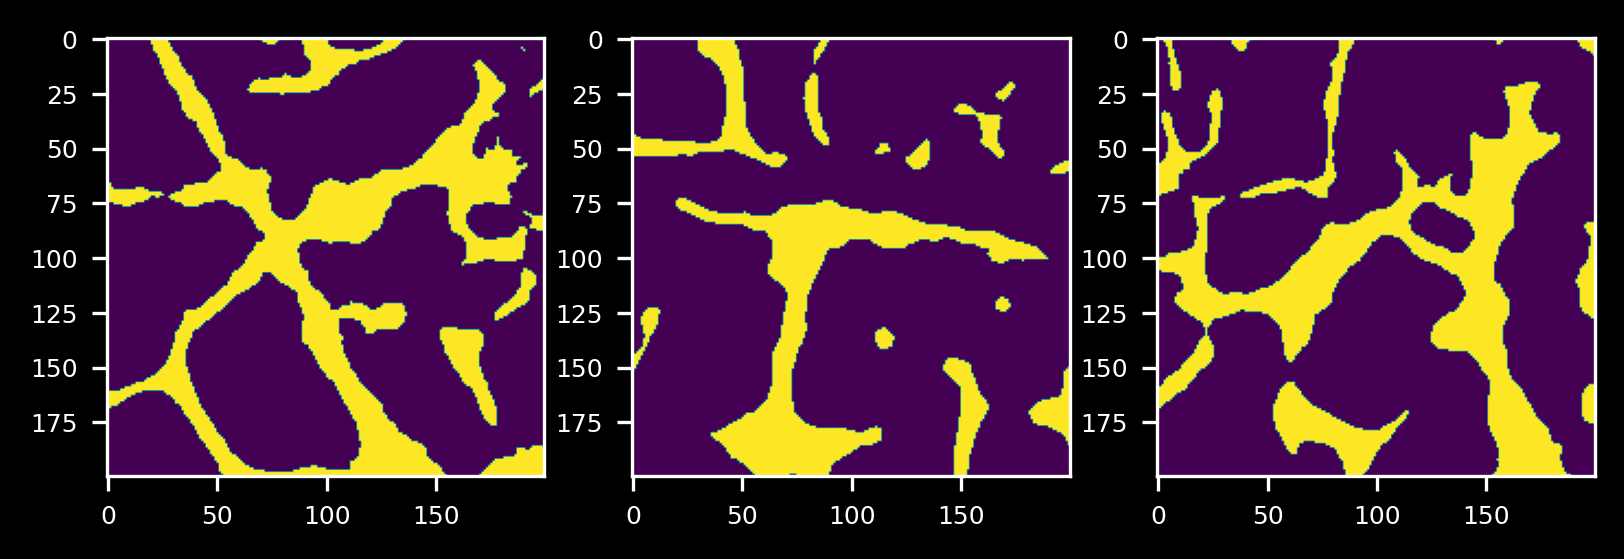

In [29]:
plot_midplanes(BW3)

### Recalculate Trabecular thickness (Tb.Th) after erosion

In [30]:
thickness_stats = calc_structure_thickness_statistics(BW3, vs, 0)
print(
    f"Thickness: {thickness_stats[0]:0.3f} +/- {thickness_stats[1]:0.3f}"
)

Thickness: 0.222 +/- 0.107


---
# Dependencies

In [99]:
import watermark

In [ ]:
%load_ext watermark

%watermark
%watermark --iversions

---
# Acknowledgements
- This notebook was developed within [Building the Jupyter Community in MSK Imaging Research](https://github.com/JCMSK/2022_JCW), a Jupyter Community Workshop sponsored by [NUMFocus](https://numfocus.org/)